<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/ASSGN_q3_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.8 MB/s eta 0:00:00


In [42]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.colab import output
output.enable_custom_widget_manager()

In [43]:
feature_df = pd.read_csv("X_train.txt", header=None, delim_whitespace=True)
label_df = pd.read_csv("y_train.txt", header=None, delim_whitespace=True)

In [25]:
def regularized_cov(X, lambda_reg):
    # Note: Ensure the input X is in the form where rows are observations
    sigma = np.cov(X, rowvar=False)  # rowvar=False to treat rows as observations
    n_features = X.shape[1]
    sigma += lambda_reg * np.eye(n_features)
    return sigma

In [29]:
# Access rows/columns by indexing
X = feature_df.to_numpy()
Y = label_df.to_numpy()

# Define a label encoder to encode labels numerically
le = preprocessing.LabelEncoder()
labels = le.fit_transform(Y)  # Fit and transform in one step

# Estimate class priors
unique_classes, counts = np.unique(Y, return_counts=True)
class_priors = counts / counts.sum()  # Normalize counts to sum to 1
num_classes = len(unique_classes)

# Print results to verify
print("Class Priors:", class_priors)
print("Number of Classes:", num_classes)

Class Priors: [0.16675734 0.14594668 0.13411317 0.17491839 0.18688792 0.1913765 ]
Number of Classes: 6


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [73]:
# Compute mean vectors
mean_vectors = np.array([X[labels == i].mean(axis=0) for i in range(num_classes)])

# Regularization parameter
lambda_reg = 5 / X.shape[1]

# Compute regularized covariance matrices for each class
regularized_cov_matrices = np.array([
    regularized_cov(X[labels == i], lambda_reg)
    for i in range(num_classes)
])

# Number of samples per class
N_per_l = counts

In [74]:
gmm = {
    'priors': class_priors,
    'mu': mean_vectors,
    'Sigma': regularized_cov_matrices
}

print(N_per_l)


[1226 1073  986 1286 1374 1407]


In [75]:
# ERM classification rule (min prob. of error classifier IF 0-1 loss)
def perform_erm_classification(X, Lambda, gmm_params, C):
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['mu'][i], gmm_params['Sigma'][i]) for i in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)

    # If 0-1 loss, you could instead compute MAP result: np.argmax(class_posteriors, axis=0)
    return np.argmin(risk_mat, axis=0)

In [76]:
%matplotlib widget

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

Confusion Matrix (rows: Predicted class, columns: True class):


Text(0.5, 0, 'True Labels')

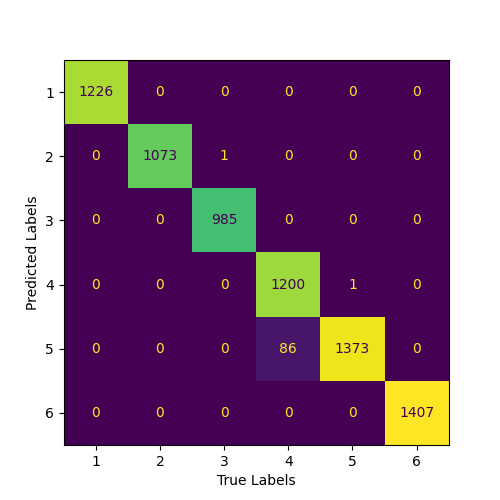

In [77]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm, num_classes)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
fig, ax = plt.subplots(figsize=(5, 5))
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, ax=ax,
                                                       display_labels=['1', '2', '3', '4', '5', '6'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

In [78]:
# Total number of rows/samples
N = len(feature_df.index)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total number of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Total number of Misclassified Samples: 88
Empirically Estimated Probability of Error: 0.0120
